In [1]:
import numpy as np
import corner
import pandas as pd
import torch
from baobab.sim_utils import add_g1g2_columns
import lenstronomy
print(lenstronomy.__path__)
import os
import h0rton.tdlmc_utils as tdlmc_utils
from h0rton.configs import TrainValConfig, TestConfig
from h0rton.h0_inference import H0Posterior, plot_h0_histogram, h0_utils
from h0rton.trainval_data import XYCosmoData
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import norm, lognorm
from h0rton.h0_inference import plotting_utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

['/home/jwp/stage/sl/lenstronomy/lenstronomy']


In [2]:
meta = pd.read_csv('/home/jwp/stage/sl/h0rton/v7_test_td_prior=DiagonalCosmoBNNPrior_seed=1111/metadata.csv', index_col=None)

In [3]:

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='STIXGeneral', size=20, weight='bold')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2, titlesize='medium', labelsize='medium', labelweight='bold')

#plt.rcParams['text.latex.preamble'] = [r'\boldmath']

In [5]:
n_test = 200

version_id = 8

version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(version_id)
summary = pd.read_csv(os.path.join(version_dir, 'summary.csv'), index_col=None)
true_H0 = 70.0
true_Om0 = 0.3

In [6]:
# Remove lenses that haven't been analyzed (outside of the rung)
#summary = summary[~summary['id'].isin([74, 82, 126, 139, 187])]
outside_rung = summary[summary['inference_time'] == 0].index
print(outside_rung)
summary.drop(outside_rung, inplace=True)

print(summary.shape)
print(set(np.arange(n_test)) - set(summary['id'].values))

Int64Index([200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
            ...
            490, 491, 492, 493, 494, 495, 496, 497, 498, 499],
           dtype='int64', length=300)
(200, 12)
set()


In [7]:
lens_ids = summary['id'].values.astype(int)
meta = pd.read_csv('/home/jwp/stage/sl/h0rton/v7_test_td_prior=DiagonalCosmoBNNPrior_seed=1111/metadata.csv', index_col=None)

In [8]:
meta = meta.reset_index(drop=True)

In [9]:
meta.shape

(1000, 38)

In [10]:
meta['id'] = meta.index
summary = summary.join(meta, on='id', how='inner', lsuffix='', rsuffix='_meta')

In [11]:
print(summary.shape)

(200, 51)


In [12]:
summary[summary['H0_mean']<0]

,Unnamed: 0,n_img,z_lens,z_src,id,D_dt_mu,D_dt_sigma,H0_mean,H0_std,inference_time,...,src_light_n_sersic,total_magnification,true_td,true_vd,x_image,y_image,z_lens_meta,z_src_meta,measured_magnification,id_meta


## Look at one example

In [ ]:
lens_i = 187
h0_dict = np.load('/home/jwp/stage/sl/h0rton/experiments/v4/simple_mc_default/h0_dict_{0:04d}.npy'.format(lens_i), allow_pickle=True).item()

In [ ]:
samples = h0_dict['h0_samples']
weights = h0_dict['h0_weights']
z_lens = summary.iloc[lens_i]['z_lens']
z_src = summary.iloc[lens_i]['z_src']

In [ ]:
h0_dict['h0_samples']

In [ ]:
plt.close('all')
bin_heights, bin_borders, _ = plt.hist(samples, weights=weights, bins=80, alpha=0.5, density=True, edgecolor='k', color='tab:blue', range=[40.0, 100.0])
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
mean = np.average(samples, weights=weights)
std = np.average((samples - mean)**2.0, weights=weights)**0.5
print(mean, std)
popt = [mean, std, 1.0/std/np.sqrt(2*np.pi)]
x_interval_for_fit = np.linspace(bin_centers[0], bin_centers[-1], 1000) 
#plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), color='k', label='fit: mu={:0.1f}, sig={:0.1f}'.format(mean, std))
plt.plot(x_interval_for_fit, norm.pdf(x_interval_for_fit, mean, std), color='k', label='fit: mu={:0.1f}, sig={:0.1f}'.format(mean, std))
plt.show()

In [ ]:
cosmo_converter = h0_utils.CosmoConverter(z_lens, z_src)
true_D_dt = cosmo_converter.get_D_dt([70.0])[0]
print(true_D_dt)
D_dt_samples = cosmo_converter.get_D_dt(samples)

In [ ]:
def lognormal(x, mu, sig):
    return np.exp(-0.5*(np.log(x) - mu)**2.0/sig**2.0)/(x*sig*(2.0*np.pi)**0.5)

In [ ]:
bin_heights, bin_borders, _ = plt.hist(D_dt_samples, weights=weights, bins=100, alpha=0.5, density=True, edgecolor='k', color='tab:blue', range=[0.0, 2000.0])
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

# Compute the weighted mean and std analytically
lognorm_stats = h0_utils.get_lognormal_stats_naive(D_dt_samples, weights)
mu = lognorm_stats['mu']
sigma = lognorm_stats['sigma']
mode = lognorm_stats['mode']
std = lognorm_stats['std']
popt = [mu, sigma]
#x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
x_interval_for_fit = np.linspace(bin_centers[0], bin_centers[-1], 1000) 
# Overlay the fit gaussian pdf
plt.plot(x_interval_for_fit, lognormal(x_interval_for_fit, *popt), color='k', label='fit: mode={:0.1f}, std={:0.1f}'.format(mode, std))
plt.axvline(x=true_D_dt, linestyle='--', color='red', label='truth')
plt.show()

## Discard extra examples outside the rung

In [ ]:
# Lens 18 is known to be faulty (5 time delays)
# Lens 201 was back-up
#summary.drop([99, 100, 174], inplace=True)
#summary.drop([200], inplace=True)

In [ ]:
#summary.drop(summary[summary['H0_std']<0].index, inplace=True)
#summary.reset_index(drop=True, inplace=True)

In [13]:
summary.tail()

,Unnamed: 0,n_img,z_lens,z_src,id,D_dt_mu,D_dt_sigma,H0_mean,H0_std,inference_time,...,src_light_n_sersic,total_magnification,true_td,true_vd,x_image,y_image,z_lens_meta,z_src_meta,measured_magnification,id_meta
195,195,2.0,0.970022,2.251121,195,9.014992,0.032546,66.276575,2.156722,7.331447,...,2.897740,5.865668,"[-212.89371272462614, -81.76825212623147]",-1.0,"[1.2383349494351483, -0.09908417405183252]","[0.47955469504886494, -1.01392525502905]",0.970022,2.251121,"[2.8094173180539324, 2.3584157529121303]",195
196,196,2.0,0.590903,1.676160,196,8.334403,0.032620,68.597107,2.230979,7.533992,...,4.027533,5.181319,"[-70.88102372974262, -5.2093023716435045]",-1.0,"[-1.3613167295479334, 0.13797719316184257]","[0.4663981956619439, -0.30843586617358293]",0.590903,1.676160,"[2.5799864370692633, 1.3070814486777587]",196
197,197,2.0,0.760075,1.891181,197,8.636772,0.041231,71.336126,2.960311,6.063909,...,3.470137,40.703299,"[-124.45670882921051, -67.30870221618241]",-1.0,"[1.302647412787791, -0.95817337058399]","[0.24515910419813844, -0.3995483015176825]",0.760075,1.891181,"[43.62268327728952, 3.6282765337228597]",197
198,198,2.0,0.401375,2.010544,198,7.705236,0.034850,70.121325,2.458818,7.750216,...,3.523812,5.915220,"[-61.12963123057325, -31.271626293158327]",-1.0,"[1.2121370535443519, -0.6006418590308683]","[-0.10283741731535466, -0.7703330928093937]",0.401375,2.010544,"[3.632126831861519, 1.8913865439139717]",198
199,199,4.0,0.318928,2.035381,199,7.468099,0.043421,66.679163,2.885880,4.017181,...,3.436548,28.866685,"[-47.53226547309089, -35.50961672312518, -35.4...",-1.0,"[0.6764063919616748, -1.0647494351839915, -1.1...","[1.1980643889904747, -0.42576154799973837, 0.0...",0.318928,2.035381,"[4.330390974898815, 15.899154654006617, 13.919...",199


In [14]:
from lenstronomy.Cosmo.lcdm import LCDM
D_dt_z = []

for i in range(summary.shape[0]):
    lcdm = LCDM(z_lens=summary.iloc[i]['z_lens'], z_source=summary.iloc[i]['z_src'], flat=True)
    true_D_dt = lcdm.D_dt(H_0=true_H0, Om0=true_Om0)
    D_dt_z.append((summary.iloc[i]['D_dt_mean'] - true_D_dt)/summary.iloc[i]['D_dt_std'])

In [15]:
summary['D_dt_z'] = D_dt_z

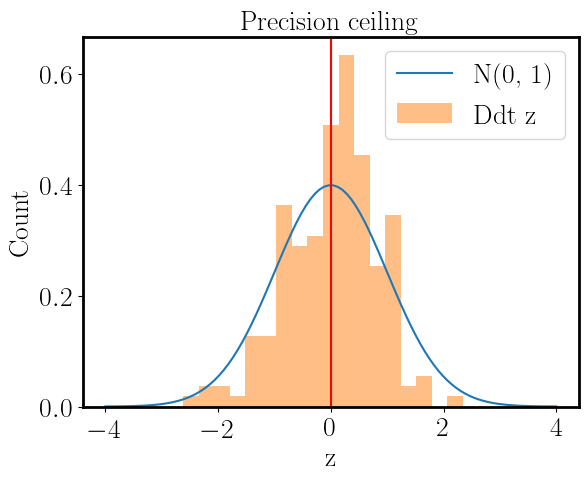

In [16]:
plt.close('all')
binning = np.linspace(-4, 4, 30)
plt.hist(D_dt_z, bins=binning, color='tab:orange', alpha=0.5, label='Ddt z', density=True)
x_int = np.linspace(-4, 4, 100)
plt.plot(x_int, norm.pdf(x_int, 0, 1), label='N(0, 1)')
plt.title('Precision ceiling')
plt.ylabel('Count')
plt.legend()
plt.axvline(0, color='r')
#plt.axvline(-0.3, color='r')
#plt.xlabel(r'$ \frac{\hat H_{0, i} - \bar H_0}{\hat {\sigma, i}}$')
plt.xlabel(r'z')
plt.show()

In [18]:
summary[(summary['D_dt_z']<0) & (summary['D_dt_z']>-0.3)]['id'].values.astype(int)

array([  1,   2,  10,  11,  14,  23,  35,  43,  44,  45,  53,  55,  60,
        62,  68,  70,  73,  78,  80,  82,  97, 121, 130, 131, 138, 139,
       143, 171, 185, 198])

In [ ]:
#a = np.load('/home/jwp/stage/sl/h0rton/experiments/v10/mcmc_default_0.01/D_dt_dict_0000.npy', #allow_pickle=True).item()
#plt.hist(a['D_dt_samples'], bins=50, range=[0, 10000])
#plt.axvline(a['true_D_dt'],color='r')
#plt.show()

In [17]:
td = []
from ast import literal_eval
for i in range(200):
    to_compare = []
    t = np.sort(literal_eval(summary.iloc[i]['measured_td_wrt0']))
    if len(t) == 3:
        to_compare.append([t[1] - t[0], t[2] - t[1]])
    else:
        to_compare.append(t[0])
    td.append(np.min(np.abs(to_compare)))


KeyError: 'measured_td_wrt0'

In [16]:
summary['min_td_offset'] = td

0.13834811070622877


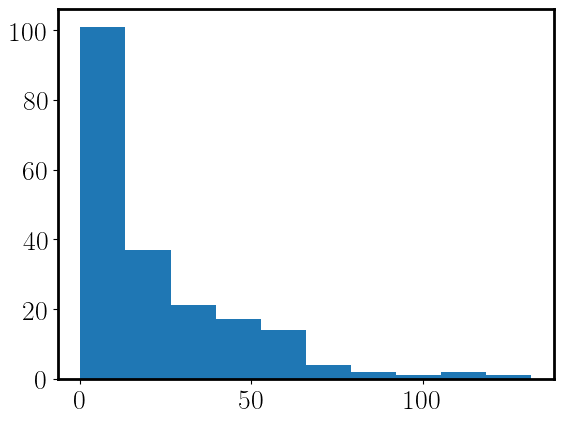

In [17]:
plt.hist(summary['min_td_offset'] )
print(np.min(summary['min_td_offset']))
plt.show()

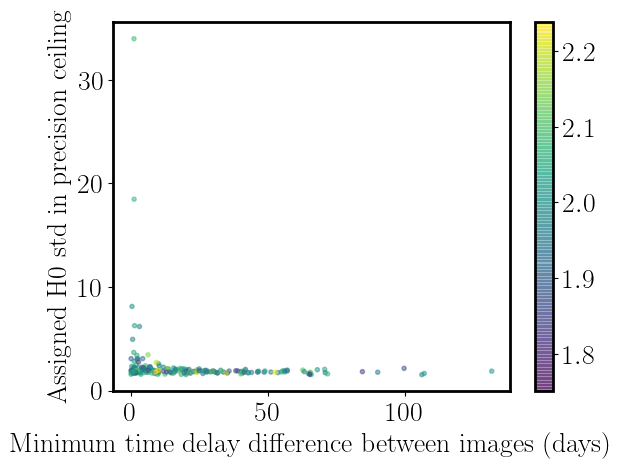

In [18]:
plt.close('all')
plt.scatter(summary['min_td_offset'].values, summary['H0_std'].values, marker='.', c=summary['lens_mass_gamma'].values, alpha=0.5)
plt.ylabel('Assigned H0 std in precision ceiling')
plt.xlabel('Minimum time delay difference between images (days)')
plt.colorbar()
plt.show()

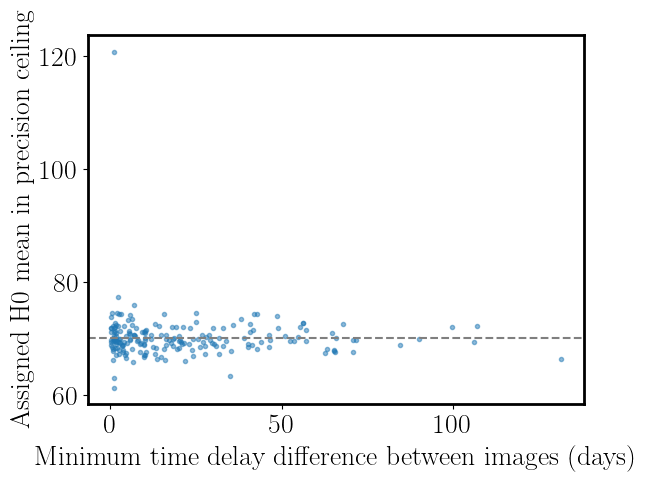

In [19]:
plt.close('all')
plt.scatter(summary['min_td_offset'].values, summary['H0_mean'].values, marker='.', alpha=0.5)
plt.axhline(70, color='tab:gray', linestyle='--')
plt.ylabel('Assigned H0 mean in precision ceiling')
plt.xlabel('Minimum time delay difference between images (days)')
plt.show()

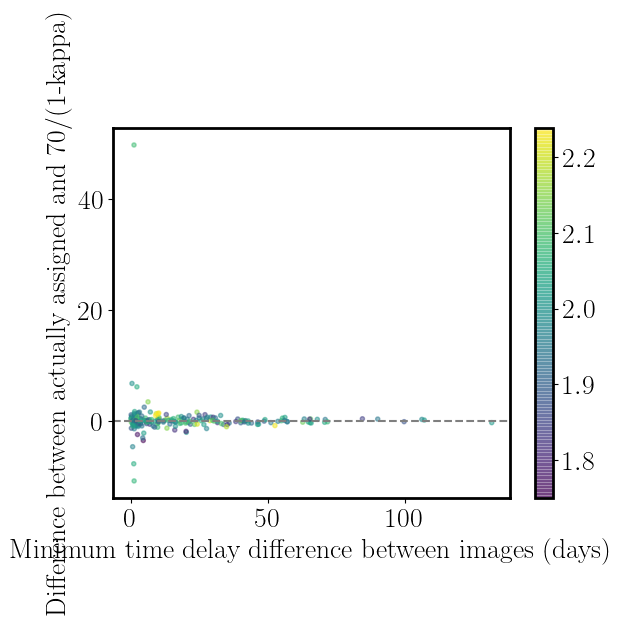

In [20]:
plt.close('all')
plt.scatter(summary['min_td_offset'].values, summary['H0_mean'].values - 70/(1 - summary['kappa_ext'].values), c=summary['lens_mass_gamma'].values, marker='.', alpha=0.5) #label='70/(1-k)')
#plt.scatter(summary['min_td_offset'].values,, color='tab:orange', marker='.', alpha=0.5, label='H0 mean')
plt.axhline(0, color='tab:gray', linestyle='--')
plt.ylabel('Difference between actually assigned and 70/(1-kappa)')
plt.xlabel('Minimum time delay difference between images (days)')
#plt.legend()
plt.colorbar()
plt.show()

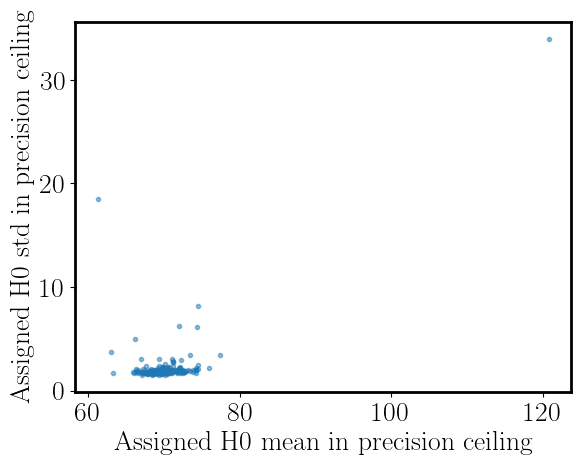

In [21]:
plt.close('all')
plt.scatter(summary['H0_mean'].values, summary['H0_std'].values, marker='.', alpha=0.5)
plt.xlabel('Assigned H0 mean in precision ceiling')
plt.ylabel('Assigned H0 std in precision ceiling')
plt.show()

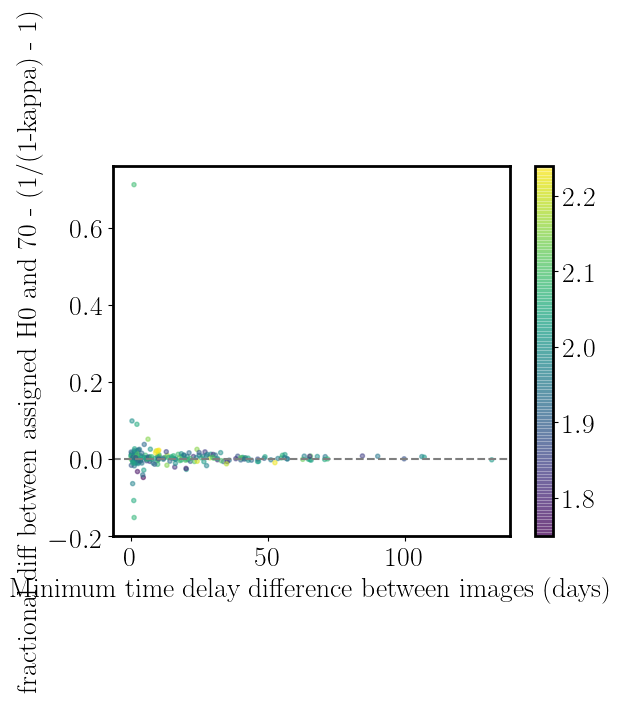

In [22]:
plt.close('all')
plt.scatter(summary['min_td_offset'].values, (summary['H0_mean'].values - 70)/70 - (1.0/(1 - summary['kappa_ext'].values) - 1), c=summary['lens_mass_gamma'].values, marker='.', alpha=0.5) #label='70/(1-k)')
#plt.scatter(summary['min_td_offset'].values,, color='tab:orange', marker='.', alpha=0.5, label='H0 mean')
plt.axhline(0, color='tab:gray', linestyle='--')
plt.ylabel('fractional diff between assigned H0 and 70 - (1/(1-kappa) - 1)')
plt.xlabel('Minimum time delay difference between images (days)')
#plt.legend()
plt.colorbar()
plt.show()

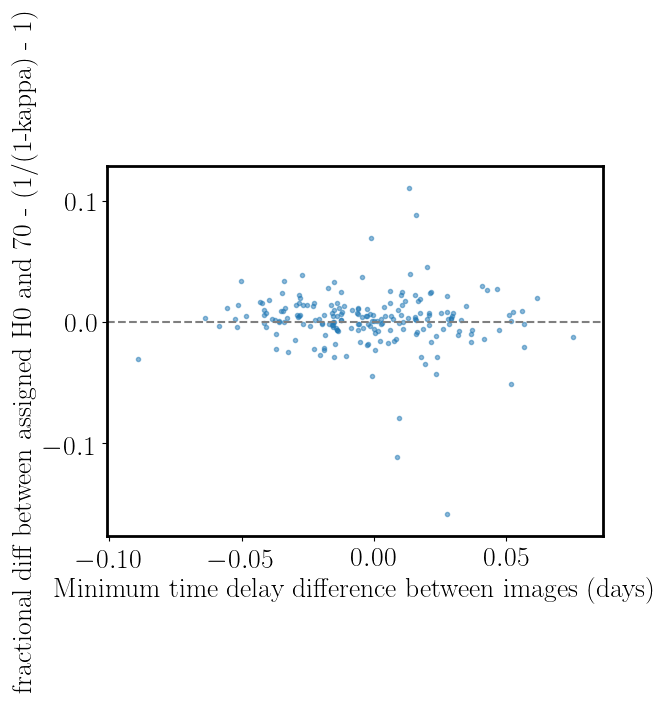

In [19]:
plt.close('all')
plt.scatter(summary['kappa_ext'].values, (summary['H0_mean'].values - 70)/70 - (1.0/(1 - summary['kappa_ext'].values) - 1), color='tab:blue', marker='.', alpha=0.5) #label='70/(1-k)')
#plt.scatter(summary['min_td_offset'].values,, color='tab:orange', marker='.', alpha=0.5, label='H0 mean')
plt.axhline(0, color='tab:gray', linestyle='--')
plt.ylabel('fractional diff between assigned H0 and 70 - (1/(1-kappa) - 1)')
plt.xlabel('Minimum time delay difference between images (days)')
#plt.legend()
plt.show()

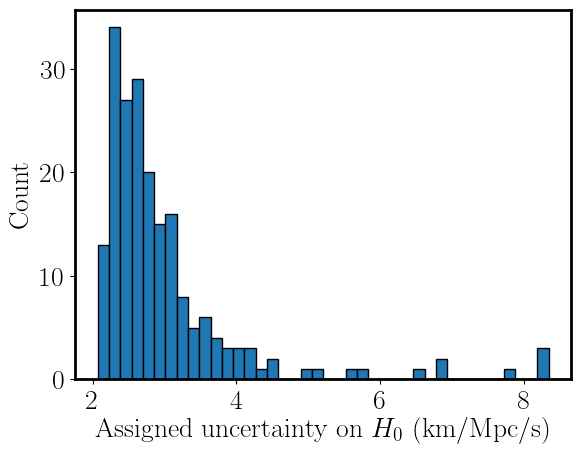

In [20]:
plt.hist(list(summary['H0_std']), edgecolor='k', bins=40)
plt.ylabel('Count')
plt.xlabel('Assigned uncertainty on $H_0$ (km/Mpc/s)')
plt.show()

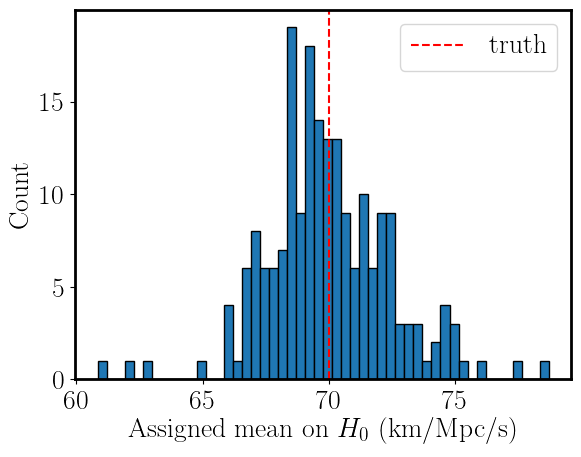

In [21]:
plt.close('all')
plt.hist(list(summary['H0_mean']), edgecolor='k', bins=50)
plt.axvline(70, c='r', linestyle='--', label='truth')
plt.ylabel('Count')
plt.xlabel('Assigned mean on $H_0$ (km/Mpc/s)')
plt.legend()
plt.show()

In [22]:
w = 1.0/summary['H0_std'].values**2.0
w_mean = np.average(summary['H0_mean'].values, weights=w)
summary['z'] = (summary['H0_mean'].values - w_mean)/summary['H0_std']
summary['z2'] = (summary['H0_mean'].values - true_H0)/summary['H0_std']
single_std = np.average((summary['H0_mean'].values-w_mean)**2, weights=w)**0.5
summary['z_single_std'] = (summary['H0_mean'].values - w_mean)/single_std
print(1.0/(np.average(1.0/summary['H0_std'].values**2.0)**0.5))
print(w_mean, single_std)

2.724952322370017
69.84160728213665 2.1350357625752143


In [23]:
summary['keep'] = True #(np.abs(summary['z']) < 3.0)
print(summary['H0_mean'][summary['keep']].shape)
tdlmc_mean = summary['H0_mean'][summary['keep']]
tdlmc_std = summary['H0_std'][summary['keep']]
#summary['valid_sample_fraction'] = frac

summary['g'] = ((summary['H0_mean'] - true_H0)/summary['H0_std'])**2.0
summary['log_g'] = np.log10(summary['g'])
summary['p'] = (summary['H0_std']/true_H0)
summary['a'] = (summary['H0_mean'] - true_H0)/true_H0

# Test-set-side metrics
G = tdlmc_utils.get_goodness(tdlmc_mean,tdlmc_std, true_H0)
P = tdlmc_utils.get_precision(tdlmc_std, true_H0)
A = tdlmc_utils.get_accuracy(tdlmc_mean, true_H0)
print(G, np.log10(G), P, A)

(200,)
0.6172714556501907 -0.20952380555392586 0.04288165514763296 -0.0003409828267327085


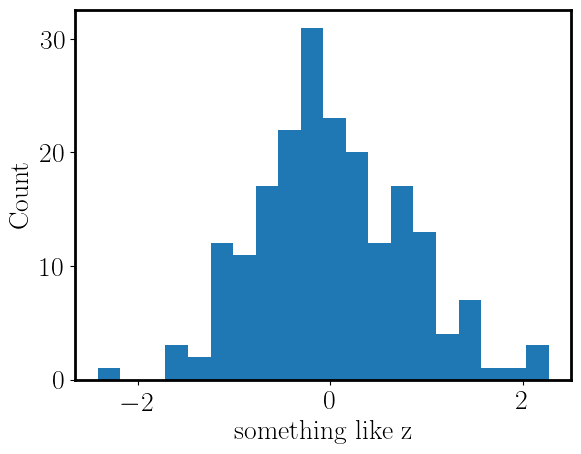

In [24]:
plt.hist(summary['z'].values, bins=20)
plt.ylabel('Count')
plt.xlabel('something like z')
plt.show()

In [25]:
print(len(summary[summary['n_img']==2]), len(summary[summary['n_img']==4]))
summary['is_quad'] = (summary['n_img'] == 4)
print(len(summary[~summary['is_quad']]), len(summary[summary['is_quad']]))


doubles = summary[~summary['is_quad']].iloc[:n_test]
quads = summary[summary['is_quad']].iloc[:n_test]

91 109
91 109


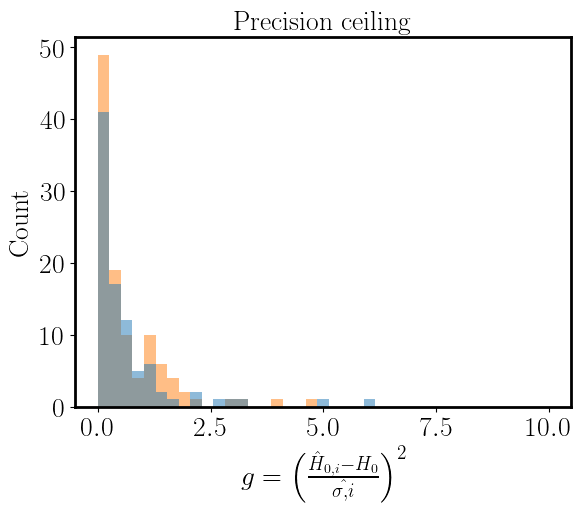

In [26]:
plt.close('all')
binning = np.linspace(0, 10, 40)
plt.hist(quads['g'], bins=binning, color='tab:orange', alpha=0.5)
plt.hist(doubles['g'], color='tab:blue', bins=binning, alpha=0.5)
plt.title('Precision ceiling')
plt.ylabel('Count')
plt.xlabel(r'$g = \left( \frac{\hat H_{0, i} - H_0}{\hat {\sigma, i}} \right)^2$')
plt.show()

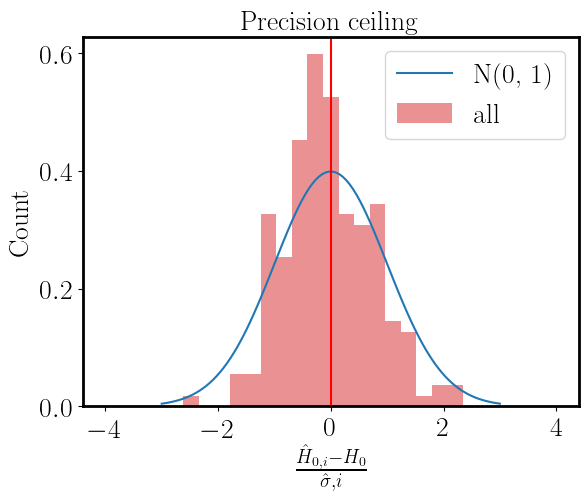

In [27]:
plt.close('all')
binning = np.linspace(-4, 4, 30)
#plt.hist(quads['z2'], bins=binning, color='tab:orange', alpha=0.5, label='quads', density=True)
#plt.hist(doubles['z2'], color='tab:blue', bins=binning, alpha=0.5, label='doubles', density=True)
plt.hist(summary['z2'], color='tab:red', bins=binning, alpha=0.5, label='all', density=True)
x_int = np.linspace(-3, 3, 100)
plt.plot(x_int, norm.pdf(x_int, 0, 1), label="N(0, 1)")
plt.title('Precision ceiling')
plt.ylabel('Count')
plt.legend()
#plt.axvline(-0.35, color='red')
#plt.axvline(0.4, color='red')
#plt.axvline(1.5, color='red')
plt.axvline(0.0, color='red')
#plt.xlabel(r'$ \frac{\hat H_{0, i} - \bar H_0}{\hat {\sigma, i}}$')
plt.xlabel(r'$ \frac{\hat H_{0, i} - H_0}{{\hat{\sigma}, i}}$')
plt.show()

In [ ]:
summary[summary.isnull().any(axis=1)]

## Rung-level prediction boxplot

In [28]:
true_cosmo = FlatLambdaCDM(H0=true_H0, Om0=true_Om0)

In [ ]:
save_path = os.path.join(version_dir, 'combined_H0_no_rejection.npy')
print(save_path)
samples, log_prob = h0_utils.combine_lenses(true_cosmo, 
                         summary['D_dt_mu'][summary['keep']].values, 
                         summary['D_dt_sigma'][summary['keep']].values, 
                         summary['z_lens'][summary['keep']].values, 
                         summary['z_src'][summary['keep']].values, 
                         samples_save_path=save_path, corner_save_path='.', n_run=100, n_burn=800, n_walkers=10)

/home/jwp/stage/sl/h0rton/experiments/v8/combined_H0_normal_no_rejection.npy


100%|██████████| 900/900 [13:11<00:00,  1.14it/s]


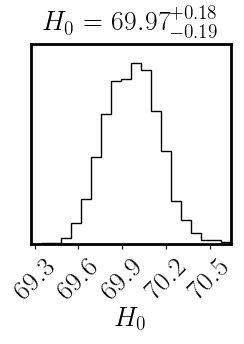

In [29]:
save_path = os.path.join(version_dir, 'combined_H0_normal_no_rejection.npy')
print(save_path)
samples, log_prob = h0_utils.combine_lenses_normal(true_cosmo, 
                         summary['D_dt_mean'][summary['keep']].values, 
                         summary['D_dt_std'][summary['keep']].values, 
                         summary['z_lens'][summary['keep']].values, 
                         summary['z_src'][summary['keep']].values, 
                         samples_save_path=save_path, corner_save_path='.', n_run=100, n_burn=800, n_walkers=10)

In [ ]:
save_path = os.path.join(version_dir, 'combined_H0_kde_no_rejection.npy')
print(save_path)
lens_ids = summary['id'].values.astype(int)
samples_dir = os.path.join(version_dir, 'simple_mc_default')
samples, log_prob = h0_utils.combine_lenses_kde(true_cosmo,
                                                lens_ids,
                                                samples_dir,
                         summary['z_lens'][summary['keep']].values, 
                         summary['z_src'][summary['keep']].values, 
                         samples_save_path=save_path, corner_save_path='.', n_run=100, n_burn=800, n_walkers=10)

In [ ]:
plt.close('all')
final_h0_samples = np.load(save_path)
print(len(final_h0_samples))
plt.axvline(np.median(final_h0_samples), color='k')
plt.axvline(np.quantile(final_h0_samples, 0.5-0.34), color='k')
plt.axvline(np.quantile(final_h0_samples, 0.5+0.34), color='k')
plt.axvline(70, color='r', linestyle='--')
plt.hist(final_h0_samples, bins=40)
plt.show()

In [ ]:
summary[summary['H0_mean'] < 70.0].shape, 39/200

In [ ]:
print(np.median(final_h0_samples))
print(np.quantile(final_h0_samples, 1 - 0.16) - np.quantile(final_h0_samples, 0.5))
print(np.quantile(final_h0_samples, 0.5) - np.quantile(final_h0_samples, 0.16))


## Doubles vs. quads

In [30]:
print(version_dir)

/home/jwp/stage/sl/h0rton/experiments/v8


100%|██████████| 600/600 [08:53<00:00,  1.12it/s]


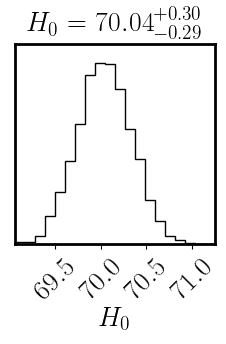

In [31]:
double_mcmc_samples, logL = h0_utils.combine_lenses_normal(true_cosmo, doubles['D_dt_mean'].values, doubles['D_dt_std'].values, doubles['z_lens'].values, doubles['z_src'].values, samples_save_path=os.path.join(version_dir, 'combined_H0_doubles.npy'), corner_save_path='.', n_run=100, n_burn=500, n_walkers=20)

100%|██████████| 600/600 [10:26<00:00,  1.04s/it]


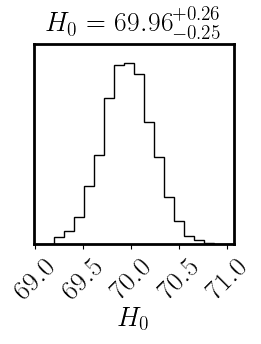

In [32]:
quad_mcmc_samples, logL = h0_utils.combine_lenses_normal(true_cosmo, quads['D_dt_mean'].values, quads['D_dt_std'].values, quads['z_lens'].values, quads['z_src'].values, samples_save_path=os.path.join(version_dir, 'combined_H0_quads.npy'), corner_save_path='.', n_run=100, n_burn=500, n_walkers=20)

In [ ]:
plt.close('all')
save_path = os.path.join(version_dir, 'combined_H0_doubles.npy')
final_h0_samples = np.load(save_path)
print(len(final_h0_samples))
plt.axvline(np.median(final_h0_samples), color='r')
plt.axvline(np.quantile(final_h0_samples, 0.5-0.34), color='r')
plt.axvline(np.quantile(final_h0_samples, 0.5+0.34), color='r')
plt.axvline(70, color='r', linestyle='--')
plt.hist(final_h0_samples, bins=40)
plt.show()

## Inference time

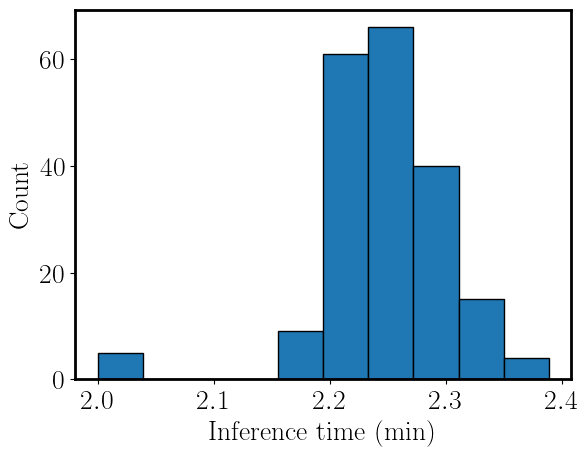

In [35]:
plt.hist(summary['inference_time'], bins=10, edgecolor='k')
plt.ylabel('Count')
plt.xlabel('Inference time (min)')
plt.show()

In [ ]:
summary[summary['id'].isin([25, 120])]

In [ ]:
summary[summary['z']>3]

In [ ]:
summary['inference_time'].median(), summary['inference_time'].mean()

In [ ]:
summary[summary['H0_std'] > 6.0]

## Quartiles

In [ ]:
sorted_by_std = summary.sort_values(by='std')['id'].values

In [ ]:
# Quartiles of precision
np.array_split(sorted_by_std, 3)

In [ ]:
summary[summary['id'] == 161]